# 1. Introduction :
<div style="text-align: justify">For this laboratory of Artificial Intelligence, we are going to train a model in order to be able to predict if a transaction is fraudulent or not based on the Xente Fraud Challenge. We will the data from Xente and the different concepts we studied during the course and laboratories such as Machine Learning, Feature Ingeniering.</div> 


# 2. Import Libraries :
<div style="text-align: justify">First of all we need to import all the libraries we are going to use during this project.</div>

In [240]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from imblearn.over_sampling import SMOTE


# 3. Data loading :
<div style="text-align: justify"> Now we need to load the data we get from Xente. This data gives us a large number of transactions with some informations such as the time of the transaction or the account Id from which this transaction commes. It also gives us a Fraud Result, which is very important, because it is what we will use later on to train the model in order to predict if the transactions are fraudulent or not. We are calling this data the training_data and we do a describe in order to get a summary of the attributes of the column. </div> 


In [241]:
training_data = pd.read_csv("data/training.csv")
training_data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


## 3.1 Checking Data: 
<div style="text-align: justify">
As this is going to be our trainning data, it is really important to check if our data is balanced or imbalanced before using it. An inbalanced data set is the one that has biased class proportions, in other words, which has classes that are much more important than others. <br>
In our case, as we can see in the image <i>' Imbalanced data '</i>, we have significantly more non-fraudelent transactions than fraudulent ones. We have 193 fradulent transactions, compared to the 95469 non fraudulent ones, so our data is extremely imbalanced.<br>
 This is a problem because, with some few fraudulent data, the training model is going to spend most of its time on non fraudulent transactions and will not learn enough from fraudulent trasactions. In order to handle this, we will apply further on, an upweighting technique called Smote, which will add to the dataset synthetically genereted fraudulent transactions.
</div> 
  

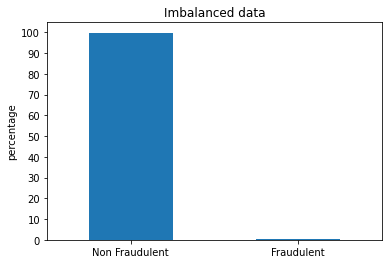

number of fraudulent transcactions in the training_data:  193
number of non fraudulent transcactions in the training_data:  95469


In [242]:
value = training_data['FraudResult'].value_counts()
proprtions = value / len(training_data) * 100
axe = proprtions.plot (kind = 'bar')
axe.yaxis.set_major_locator(ticker.MultipleLocator(10))
axe.set_ylabel('percentage')
custom_labels = ['Non Fraudulent', 'Fraudulent']
axe.set_xticklabels(custom_labels, rotation=0, ha='center')
axe.set_title('Imbalanced data')
plt.show()
ones = (training_data['FraudResult'] == 1).sum()
zero = (training_data['FraudResult'] == 0).sum()
print("number of fraudulent transcactions in the training_data: ",ones)
print("number of non fraudulent transcactions in the training_data: ", zero)

# 4. Cleaning data: 
## 4.1 Ids:
<div style="text-align: justify"> First of all we need to clean all the Id columns because the elements of these columns comme with the Id number and also the name of the column, for example, <i>TransactionId_76871</i>. In order to use the Ids to train our model, we only need the numbers, so we deleted the strings from these columns.</div> 
 

In [243]:
# columns with Ids
id_cols = ['TransactionId', 'SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
# remove the strings that are before the underscore in id_cols
for col in id_cols:
    training_data[col] = training_data[col].apply(lambda x : x.split("_")[-1])

training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [244]:
# Count the number of distinct elements in the training_data columns:
training_data.nunique()
#training_data.dtypes

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64

## 4.2 Set Index and drop:
<div style="text-align: justify">The transaction Id is the unique transaction identifier on the platform, we choose to set the transaction as an Index in order to improve the data organization, we try to arrange data in a way to facilitate analysis. Setting the index helps to organize, manipulate and the alignment of data in machine learning. In our case we choosed transaction id as index. <br>
The drop function is used to drop specified columns. Before dropping any column we used the nunique method to count the number of distinct elements in each columns. we notice that 'CurrencyCode' and 'CountryCode' have only one distinct value and these columns may not provide any irrelevant information to our model and can degrades its performance, so we decided to delete them from training_data.
</div> 

In [245]:
training_data.drop(['CurrencyCode','CountryCode'],axis = 1, inplace=True)
training_data.set_index('TransactionId')

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,96668,4841,3829,3078,4,6,financial_services,2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
91597,3503,3439,2643,3874,6,10,airtime,3,1000.0,1000,2019-02-13T09:54:25Z,2,0
82501,118602,4841,3829,3874,4,6,financial_services,2,-20.0,20,2019-02-13T09:54:35Z,2,0


## 4.3 Split TransactionStartTime:
<div style="text-align: justify">
In order to get more information of the transaction time column, we are splitting each value into 7 new columns were we are putting the year, month, day, hour, minute, second and day of the week in which the transaction took place. Afterthat, we drop the <i> TransactionStartTime </i> column as we don't need it anymore.
</div> 

In [246]:
training_data['year'] = pd.to_datetime(training_data['TransactionStartTime']).dt.year
training_data['month'] = pd.to_datetime(training_data['TransactionStartTime']).dt.month
training_data['day'] = pd.to_datetime(training_data['TransactionStartTime']).dt.day
training_data['hour'] = pd.to_datetime(training_data['TransactionStartTime']).dt.hour
training_data['minute'] = pd.to_datetime(training_data['TransactionStartTime']).dt.minute
training_data['second'] = pd.to_datetime(training_data['TransactionStartTime']).dt.second
training_data['day_of_week'] = pd.to_datetime(training_data['TransactionStartTime']).dt.dayofweek


# drop TransactionStartTime
training_data.drop(["TransactionStartTime"] ,axis = 1, inplace=True)
training_data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,year,month,day,hour,minute,second,day_of_week
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2,0,2018,11,15,2,18,49,3
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2,0,2018,11,15,2,19,8,3
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2,0,2018,11,15,2,44,21,3
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2,0,2018,11,15,3,32,55,3
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2,0,2018,11,15,3,34,21,3


In [247]:
# Count the number of distinct elements in the training_data columns:
training_data.nunique()

TransactionId      95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CustomerId          3742
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
Amount              1676
Value               1517
PricingStrategy        4
FraudResult            2
year                   2
month                  4
day                   31
hour                  24
minute                60
second                60
day_of_week            7
dtype: int64

## 4.4 Categorical values:
<div style="text-align: justify">
Another problem we have on our training data is that we have categorical variables in <i>ProductCategory</i>. In order to solve this, we are going to apply One-Hot Encoding. This means that we are going to create a new column for each of the categories in <i>ProductCategory</i> and we will indicate for each transaction if it belongs to this category or not with a 1 or a 0 in the new columns. As we use the One-Hot Encoding, we don't need anymore the <i>ProductCategory</i> column, so we can drop it.  
</div> 

In [248]:

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(training_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_train.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)
# One-hot encoding removed index; put it back
OH_cols_train.index = training_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_train = training_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_train = pd.concat([num_train, OH_cols_train], axis=1)

# Ensure all columns have string type
OH_train.columns = OH_train.columns.astype(str)

OH_train.head()

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,day_of_week,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Feature Engineering:
## 5.1 Mutual Information:
<div style="text-align: justify">
Mutual information measures the relationship between two values, it measures the statistical dependence between two variables, i.e how much knowledge of a variable provides information about the other variable.

In this case we measure the dependence between Fraud result and the other variables in order to identify which feature has the most important information to predict the target. Mutual information provides a quantitative measuer between FraudResult and the other variables, it can help to visualize the impact of a feature on the prediction. 
</div>

In [249]:
OH_train.describe()
OH_train = OH_train.apply(pd.to_numeric,errors = "coerce")
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 
discrete_features

TransactionId          int64
BatchId                int64
AccountId              int64
SubscriptionId         int64
CustomerId             int64
ProviderId             int64
ProductId              int64
ChannelId              int64
Amount               float64
Value                  int64
PricingStrategy        int64
year                   int64
month                  int64
day                    int64
hour                   int64
minute                 int64
second                 int64
day_of_week            int64
ProductCategory_0    float64
ProductCategory_1    float64
ProductCategory_2    float64
ProductCategory_3    float64
ProductCategory_4    float64
ProductCategory_5    float64
ProductCategory_6    float64
ProductCategory_7    float64
ProductCategory_8    float64
dtype: object

In [250]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  

PricingStrategy      0.016313
Amount               0.012792
ProviderId           0.010070
year                 0.007916
CustomerId           0.006886
day                  0.001198
second               0.000310
ProductCategory_7    0.000130
ProductCategory_5    0.000000
Name: MI Scores, dtype: float64

Years:  2
Months:  4


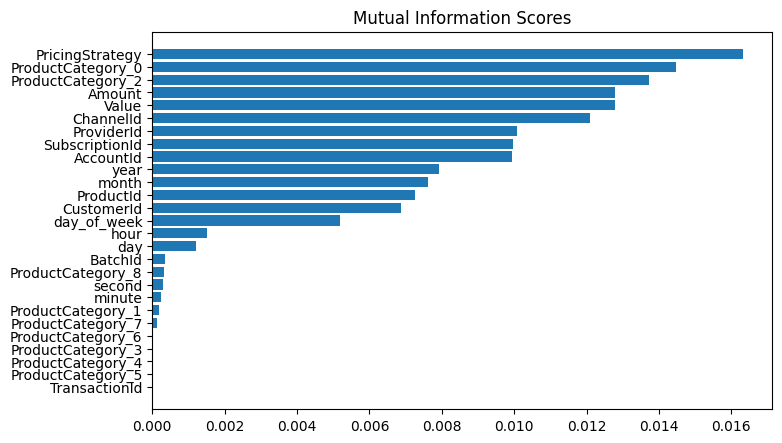

In [251]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

print('Years: ' ,OH_train.year.nunique())
print('Months: ' ,OH_train.month.nunique())

<div style="text-align: justify">
As we can see from the mutual information scores, the minutes and the seconds have a much smaller inpact compared to the hours and the day of the week. For this reason, we decided to drop this two columns from our training dataset. <br>
Also, as we only have data from four months, we will not be able to train our model and predict the result of the transactions for the rest of the months of the year, so we decided to drop this column.<br>
Finally, the data commes from only two different years, which we believe that is not significantly enought to use this data in order to predict whether or not the transactions are going to be fradulent based on the year.
</div> 

In [252]:
OH_train.drop(["minute","second", "year", "month"] ,axis = 1, inplace=True)
OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,day_of_week,ProductCategory_0,ProductCategory_1,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="text-align: justify">
In our data set we had a column that contains different timestamps, which is the day column.To understand how the different parts of the day contribute to predict our target variable we decided to split the day column into three different columns(morning, afternoon and night). Our objective was to analyze the impact of each part of the day to the target variable.
</div>

In [253]:
OH_train['morning'] = np.where((OH_train['hour'] >= 5) & (OH_train['hour'] < 13), 1, 0)
OH_train['night'] = np.where((OH_train['hour'] >= 21) | (OH_train['hour'] < 5), 1, 0)
OH_train['afternoon'] = np.where((OH_train['hour'] >= 13) & (OH_train['hour'] < 21), 1, 0)
#OH_train.loc[100:200, ['night','afternoon','morning', 'hour']]
#OH_train.loc[(OH_train.hour >= 23)]
OH_train.drop(["hour"] ,axis = 1, inplace=True)
OH_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ChannelId,Amount,Value,...,ProductCategory_2,ProductCategory_3,ProductCategory_4,ProductCategory_5,ProductCategory_6,ProductCategory_7,ProductCategory_8,morning,night,afternoon
0,76871,36123,3957,887,4406,6,10,3,1000.0,1000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,73770,15642,4841,3829,4406,4,6,2,-20.0,20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,26203,53941,4229,222,4683,6,1,3,500.0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,380,102363,648,2185,988,1,21,3,20000.0,21800,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
4,28195,38780,4841,3829,988,4,6,2,-644.0,644,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


<div style="text-align: justify">
We are now calculating the Mutual Information scores in order to see the impact of the new time columns we created. We can see that, most of the fraudulent transactions happen during the afternoon and the morning. This information is very useful, as we will be able to predict that if the transaction is made during the night is less likely going to be fraudulent than one made during the morning or afternoon.
</div>

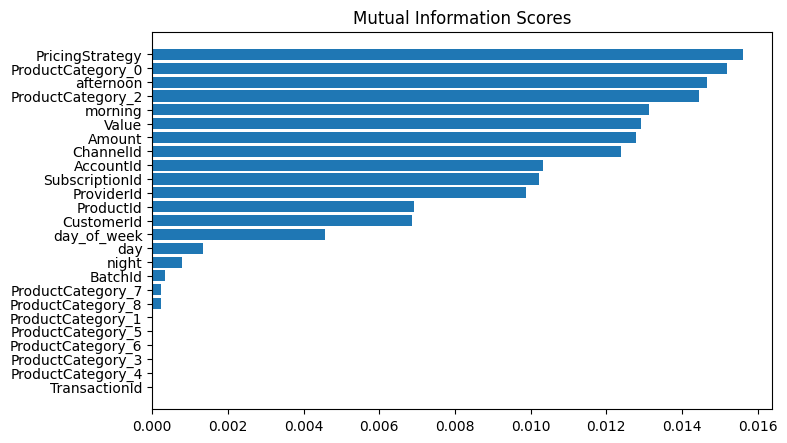

In [254]:
X = OH_train.copy()

y = X.pop('FraudResult')

discrete_features = X.dtypes 

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [255]:
# Save the cleaned data in a new file in order to used it later to train our model
OH_train.to_csv('data/cleaned_data.csv', index=False)

# 6. Model:
## 6.1 Get data:
<div style="text-align: justify">
In this step, we are going to get the training data for our model, which is the data we cleaned previously and the test data that we get from Xente in order to check the performances of our model.
</div>

In [256]:
df = pd.read_csv('data/cleaned_data.csv')
test_data = pd.read_csv('data/test.csv')

test_data.set_index("TransactionId", inplace=True)

df.set_index("TransactionId", inplace=True)
test_data.drop(["CurrencyCode", "CountryCode"] ,axis = 1, inplace=True)

## 6.3 Choosing features:
<div style="text-align: justify">
we have choosed our feature based on mutual information plots which is an effective way to select relevant features for the model. We have choosed the feature based on their score in relation with the target variable. Features with higher score are more informative and helps more to predict the target variable. For example in our case we can see that <i>'PricingStrategy'</i> has the highest score compared to the other potential feature, it is very important to choose features with the highest score because they have strong connection with <i>'FraudResult'</i>.
</div>

In [257]:
# choosing Feautures
training_features = [
    'PricingStrategy', 
    'Value',
    'CustomerId',
    'ProviderId',
    'ProductId',
    'ChannelId',
    'AccountId', 
    'afternoon', 
    'morning', 
    'night', 
    'day_of_week', 
    'ProductCategory_0', 
    'ProductCategory_2']

X = df[training_features]
y = df.FraudResult
X.head()

,PricingStrategy,Value,CustomerId,ProviderId,ProductId,ChannelId,AccountId,afternoon,morning,night,day_of_week,ProductCategory_0,ProductCategory_2
TransactionId,,,,,,,,,,,,,
76871,2,1000,4406,6,10,3,3957,0,0,1,3,1.0,0.0
73770,2,20,4406,4,6,2,4841,0,0,1,3,0.0,1.0
26203,2,500,4683,6,1,3,4229,0,0,1,3,1.0,0.0
380,2,21800,988,1,21,3,648,0,0,1,3,0.0,0.0
28195,2,644,988,4,6,2,4841,0,0,1,3,0.0,1.0


## 6.3 Cleaning test data:
<div style="text-align: justify">
In order to test our model with the test dataset from Xente, we need to clean this dataset so that we have the same columns of the cleaned data. So we apply all the operations we did with the training data previously to <i>test_data</i>.
</div>

### 6.3.1 Clean Ids:

In [258]:

id_cols = ['SubscriptionId', 'BatchId', 'AccountId','CustomerId','ProductId','ProviderId','ChannelId']
for col in id_cols:
    test_data[col] = test_data[col].apply(lambda x : x.split("_")[-1])

### 6.3.2 Clean TransactionStartTime:
<div style="text-align: justify">
As we already decided that we are only going to use the day, hour and day of the week from the <i>TransactionStartTime</i> column, we don't need to get the other data. Once we get the needed data we can drop the column.
</div>

In [259]:
test_data['day'] = pd.to_datetime(test_data['TransactionStartTime']).dt.day
test_data['hour'] = pd.to_datetime(test_data['TransactionStartTime']).dt.hour
test_data['day_of_week'] = pd.to_datetime(test_data['TransactionStartTime']).dt.dayofweek

# drop TransactionStartTime
test_data.drop(["TransactionStartTime"] ,axis = 1, inplace=True)


### 6.3.3 Categorical variables:
<div style="text-align: justify">
We are now going to apply the One-Hot Encoding to the <i> 'ProductCategory'</i> as we did for the training data and also separate the day into morning, afternoon and night based on the hours.
</div>

In [260]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(test_data["ProductCategory"].values.reshape(-1,1)))
OH_cols_test.rename(columns=lambda x: "ProductCategory_" + str(x), inplace=True)
# One-hot encoding removed index; put it back
OH_cols_test.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_test = test_data.drop("ProductCategory", axis=1)


# Add one-hot encoded columns to numerical features
OH_test = pd.concat([num_test, OH_cols_test], axis=1)

# Ensure all columns have string type
OH_test.columns = OH_test.columns.astype(str)


OH_test.dtypes

OH_test['morning'] = np.where((OH_test['hour'] >= 5) & (OH_test['hour'] < 13), 1, 0)
OH_test['night'] = np.where((OH_test['hour'] >= 21) | (OH_test['hour'] < 5), 1, 0)
OH_test['afternoon'] = np.where((OH_test['hour'] >= 13) & (OH_test['hour'] < 21), 1, 0)
#OH_train.loc[100:200, ['night','afternoon','morning', 'hour']]
#OH_train.loc[(OH_train.hour >= 23)]
OH_test.drop(["hour"] ,axis = 1, inplace=True)

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 6.3.4 Training features:
<div style="text-align: justify">
We apply the same training features we used for the training data to the cleaned test data.
</div>

In [261]:
test = OH_test[training_features]

test.head()

,PricingStrategy,Value,CustomerId,ProviderId,ProductId,ChannelId,AccountId,afternoon,morning,night,day_of_week,ProductCategory_0,ProductCategory_2
TransactionId,,,,,,,,,,,,,
TransactionId_50600,4,1000,2857,5,3,3,2441,0,1,0,2,1.0,0.0
TransactionId_95109,2,2000,3874,5,15,3,3439,0,1,0,2,0.0,1.0
TransactionId_47357,2,50,2857,4,6,2,4841,0,1,0,2,0.0,1.0
TransactionId_28185,4,3000,3105,5,10,3,2685,0,1,0,2,1.0,0.0
TransactionId_22140,2,60,3105,4,6,2,4841,0,1,0,2,0.0,1.0


## 6.2 Balancing data:
<div style="text-align: justify">
As we explained before, our dataset is imbalanced, so we need to balance it. In order to do that we are going to use the function Smote that generates examples for the minority class. It creates new samples by interpolating between existing class samples. Smote helped our model to learn from a balanced dataset which will improve the efficienvy of the prediction.
</div>

In [262]:
X = df[training_features]
y = df.FraudResult
def balance_data(X, y):
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    return X_resampled, y_resampled 

In [265]:
X_resampled, y_resampled = balance_data(X,y)
y_resampled.head()
value = y_resampled['FraudResult'].value_counts()
proprtions = value / len(y_resampled) * 100
axe = proprtions.plot (kind = 'bar')
axe.yaxis.set_major_locator(ticker.MultipleLocator(10))
axe.set_ylabel('percentage')
custom_labels = ['Non Fraudulent', 'Fraudulent']
axe.set_xticklabels(custom_labels, rotation=0, ha='center')
axe.set_title('Imbalanced data')
plt.show()
ones = (y_resampled['FraudResult'] == 1).sum()
zero = (y_resampled['FraudResult'] == 0).sum()
print("number of fraudulent transcactions in the training_data: ",ones)
print("number of non fraudulent transcactions in the training_data: ", zero)

KeyError: 'FraudResult'

## 6.5 Decision Tree Classifier:

In [224]:
X_resampled, y_resampled = balance_data(X,y)
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)

training_forest_model = DecisionTreeClassifier(max_leaf_nodes = 72, random_state = 1)
training_forest_model.fit(train_X, train_y)
train_decision_preds = training_forest_model.predict(test)

train_decision_preds.shape

(45019,)

### 6.5.1 Max leaf nodes impact:

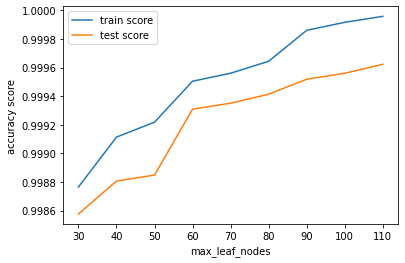

[0.99876399 0.99911315 0.99921789 0.9995042  0.99956007 0.99964386
 0.99986034 0.9999162  0.9999581 ]
[0.99857547 0.99880591 0.99884781 0.99930868 0.99935058 0.99941343
 0.99951817 0.99956007 0.99962292]


In [225]:
max_leaf_nodes_list = [30,40,50,60,70,80,90,100,110]
X_resampled, y_resampled = balance_data(X,y)
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)

train_score = np.zeros(len(max_leaf_nodes_list))
test_score = np.zeros(len(max_leaf_nodes_list))

for i, max_leaf_nodes in enumerate(max_leaf_nodes_list):
    tree = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes, random_state = 1)
    tree.fit(train_X, train_y)
    train_score[i] = accuracy_score(train_y, tree.predict(train_X))
    test_score[i] = accuracy_score(val_y, tree.predict(val_X))

plt.plot(max_leaf_nodes_list, train_score, label="train score")
plt.plot(max_leaf_nodes_list, test_score, label="test score")

plt.legend()
plt.xlabel("max_leaf_nodes")
plt.ylabel("accuracy score")
plt.show()

print(train_score)
print(test_score)

In [226]:
index_val = list(test.index.values.tolist())
data = {'TransactionId': index_val,
        'FraudResult': train_decision_preds}

model_result = pd.DataFrame(data)
model_result.shape
model_result.to_csv('data/72result.csv', index=False)

#on a un score de 0.422222 comme score public et 0.418 en score privee
#on utilisé max_leaf_nodes
# 3 - 0.134408602     0.142857142
# 30 - 0.381679389    0.392452830
  

## 6.6 Random Forest Regressor

In [227]:
X_resampled, y_resampled = balance_data(X,y)
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled,random_state = 0)

training_forest_model = RandomForestRegressor(random_state=1)
training_forest_model.fit(train_X, train_y)
train_preds = training_forest_model.predict(test)

train_preds.shape

(45019,)

In [228]:
index_val = list(test.index.values.tolist())
data = {'TransactionId': index_val,
        'FraudResult': train_preds}

df = pd.DataFrame(data)

df.to_csv('data/firstmodelresult.csv', index=False)
#on a un score de 0.52 comme score public et 0.49 en score privee 